#**Tutorial 5 - DQN and Actor-Critic**

Please follow this tutorial to understand the structure (code) of DQNs & get familiar with Actor Critic methods.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding the core concepts. Contact the TAs for further resources if needed. 


##**Part 1: DQN**

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
from scipy.special import softmax

In [ ]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
1
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
1
----
[ 0.01323574  0.17272775 -0.04686959 -0.3551522 ]
1.0
False
{}
----


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components. 

### Q-Network:
The neural network used as a function approximator is defined below

In [ ]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size 
BATCH_SIZE = 64        # minibatch size 
GAMMA = 0.99           # discount factor
LR = 5e-4               # learning rate 
UPDATE_EVERY = 20       # how often to update the network (When Q target is present) 


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class QNetwork2(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            fc3_units (int): Number of nodes in third hidden layer
        """
        super(QNetwork2, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc2_units)
        self.register_full_backward_hook4 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc3(F.relu(self.fc2(x))))

        return self.register_full_backward_hook4(x)

### Replay Buffer:

This is a 'deque' that helps us store experiences. Recall why we use such a technique.

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Truncation:
We add a line (optionally) in the code to truncate the gradient in hopes that it would help with the stability of the learning process.

## Tutorial Agent Code:


In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                 
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start                    
    ''' initialize epsilon '''

    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_window.append(score)       
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
           break
           
    return [np.array(scores),i_episode-100]

''' Trial run to check if algorithm runs and saves the data 
'''
begin_time = datetime.datetime.now()
agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)

'''
scores = dqn()


time_taken = datetime.datetime.now() - begin_time

print(time_taken)'''

'\nscores = dqn()\n\n\ntime_taken = datetime.datetime.now() - begin_time\n\nprint(time_taken)'

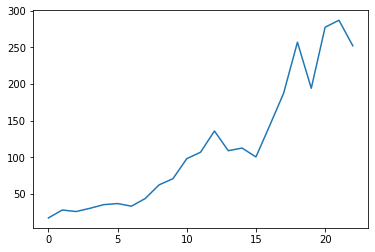

In [ ]:
plt.plot(scores[0])
plt.savefig("abc.png")

Search Grid

Hyper params tuning

In [ ]:
import torch

Buffer = [1e5, 5e4, 5e5]
eps_decay = [0.995, 0.999, 0.99]
UPDATE_EVERY = [10, 15, 20]

avg_runs = 10

for buffer in Buffer:
    for eps in eps_decay :
        for UPDATE in UPDATE_EVERY:
            x = buffer
            y = eps 
            class TutorialAgent():

                def __init__(self, state_size, action_size, seed):

                    ''' Agent Environment Interaction '''
                    self.state_size = state_size
                    self.action_size = action_size
                    self.seed = random.seed(seed)

                    ''' Q-Network '''
                    self.qnetwork_local = QNetwork2(state_size, action_size, seed).to(device)
                    self.qnetwork_target = QNetwork2(state_size, action_size, seed).to(device)
                    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

                    ''' Replay memory '''
                    self.memory = ReplayBuffer(action_size, int(x), BATCH_SIZE, seed)

                    ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
                    self.t_step = 0
                
                def step(self, state, action, reward, next_state, done):

                    ''' Save experience in replay memory '''
                    self.memory.add(state, action, reward, next_state, done)
                    
                    ''' If enough samples are available in memory, get random subset and learn '''
                    if len(self.memory) >= BATCH_SIZE: 
                        experiences = self.memory.sample()
                        self.learn(experiences, GAMMA)

                    """ +Q TARGETS PRESENT """
                    ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
                    self.t_step = (self.t_step + 1) % UPDATE
                    if self.t_step == 0:

                        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

                def act(self, state, eps=0.):

                    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                    self.qnetwork_local.eval()
                    with torch.no_grad():
                        action_values = self.qnetwork_local(state)
                    self.qnetwork_local.train()

                    ''' Epsilon-greedy action selection (Already Present) '''
                    if random.random() > eps:
                        return np.argmax(action_values.cpu().data.numpy())
                    else:
                        return random.choice(np.arange(self.action_size))

                def learn(self, experiences, gamma):
                    """ +E EXPERIENCE REPLAY PRESENT """
                    states, actions, rewards, next_states, dones = experiences

                    ''' Get max predicted Q values (for next states) from target model'''
                    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

                    ''' Compute Q targets for current states '''
                    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

                    ''' Get expected Q values from local model '''
                    Q_expected = self.qnetwork_local(states).gather(1, actions)

                    ''' Compute loss '''
                    loss = F.mse_loss(Q_expected, Q_targets)

                    ''' Minimize the loss '''
                    self.optimizer.zero_grad()
                    loss.backward()
                    
                    ''' Gradiant Clipping '''
                    """ +T TRUNCATION PRESENT """
                    for param in self.qnetwork_local.parameters():
                        param.grad.data.clamp_(-1, 1)
                        
                    self.optimizer.step()

            ''' Defining DQN Algorithm '''

            state_shape = env.observation_space.shape[0]
            action_shape = env.action_space.n

            def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay= int(y)):

                scores = []               
                ''' list containing scores from each episode '''

                scores_window_printing = deque(maxlen=10) 
                ''' For printing in the graph '''
                
                scores_window= deque(maxlen=100)  
                ''' last 100 scores for checking if the avg is more than 195 '''

                eps = eps_start
                min_length = 100                   
                ''' initialize epsilon '''
                for i in range(avg_runs):
                    temp_list = []
                    

                    for i_episode in range(1, num_episodes):
                        
                        state = env.reset()
                        score = 0
                        for t in range(max_t):
                            action = agent.act(state, eps)
                            next_state, reward, done, _ = env.step(action)
                            agent.step(state, action, reward, next_state, done)
                            state = next_state
                            score += reward
                            if done:
                                break 

                        scores_window.append(score)       
                        scores_window_printing.append(score)   
                        ''' save most recent score '''           

                        eps = max(eps_end, eps_decay*eps) 
                        ''' decrease epsilon '''

                        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
                        if i_episode % 10 == 0: 
                            
                            variable = np.mean(scores_window_printing)
                            
                            var2 = variable.item()
                            temp_list.append((var2))        
                        if i_episode % 100 == 0: 
                            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                        if np.mean(scores_window)>=195.0:
                            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                            break
                            
                    scores.append(temp_list)
                    min_length = min(len(temp_list), min_length)
            
                for i in range(avg_runs):
                    
                    scores[i] = scores[i][0:min_length]
                scores = np.matrix(scores)
                
                score_mean = np.mean(scores, axis = 0)
                score_mean = list(score_mean)
            
                sc_mean = score_mean[0]
                temp2 = torch.from_numpy(sc_mean)
                
                
            
                plot_x = []
                for i in range(len(temp2[0])):
                    plot_x.append(int(t[0][i]))
                
                plt.plot(plot_x)
                plt.title('eps_decay = ' + str(y) + 'buffer = '+ str(x) )
                plt.savefig('eps_decay = ' + str(y) + 'buffer = '+ str(x) +  '.png')
                    
                return [np.array(scores),i_episode-100]

            ''' Trial run to check if algorithm runs and saves the data '''

            begin_time = datetime.datetime.now()
            agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)


        dqn()


        time_taken = datetime.datetime.now() - begin_time

        print(time_taken)




**SOFTMAX**

In [ ]:
from scipy.special import softmax

class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, tau=1):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # ''' Epsilon-greedy action selection (Already Present) '''
        # if random.random() > eps:
        #     return np.argmax(action_values.cpu().data.numpy())
        # else:
        #     return random.choice(np.arange(self.action_size))

        ''' Softmax action selection (Already Present) '''
        # print(action_values.cpu().data.numpy()[0])
        # print(action_values.cpu().data.numpy())
        pi = softmax(action_values.cpu().data.numpy()[0]/tau)
        pi[np.isnan(pi)] = 1
        #print(pi)
        return np.random.choice(np.arange(self.action_size),p=pi)

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn(n_episodes=10000, max_t=1000, tau_start=1.0,  tau_end=0.01,  tau_decay=0.995):

    scores = []                 
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    tau =  tau_start                    
    ''' initialize  tauilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, tau)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_window.append(score)       
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        tau = max  (tau_end, tau_decay) 
        ''' decrease  tauilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
           break
    return [np.array(scores),i_episode-100]

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()
agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)


scores = dqn()


time_taken = datetime.datetime.now() - begin_time

print(time_taken)

In [ ]:
plt.plot(scores[0])
plt.title('TAU_decay = ' + str(0.995) + 'UPDATE_EVERY = '+ str(UPDATE_EVERY) + ' learningrate = ' + str(LR) + ' Episode_taken = ' + str(scores[1]))
plt.savefig('TAU_decay = ' + str(0.995) + 'UPDATE_EVERY = '+ str(UPDATE_EVERY) + ' learningrate = ' + str(LR) + ' Episode_taken = ' + str(scores[1])  +'.png')